In [1]:
from scipy.io.wavfile import read as read_wav
from IPython.display import Audio
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as skl
import librosa as lr
import numpy as np
import logging
import random
import scipy
import os

In [2]:
np.random.seed(5)
logging.warnings.filterwarnings('ignore')

### Hyper Parameters:

In [3]:
hparams = {
    'samplerate': 22050,
    'seq_length': 256,
    'hop_length': 512,
    'fft_window': 2048,
    'num_classes': 2
}

### Model Creation:

In [4]:
class GenreClassifierModel(tf.keras.Model):
    
    def __init__(self, l1, l2):
        
        super().__init__()
        
        self.L1 = tf.keras.layers.LSTM(l1, return_sequences=True)
        self.L2 = tf.keras.layers.LSTM(l2, return_sequences=False)
        self.L3 = tf.keras.layers.Dense(units=hparams['num_classes'], activation="softmax")
        
    def call(self, inputs):
        self.x = self.L1(inputs)
        self.x = self.L2(self.x)
        self.x = self.L3(self.x)
        return self.x

In [5]:
def create_model(config):
    
    l1 = config['L1']
    l2 = config['L2']
    
    # Model Definition:
    model = GenreClassifierModel(l1, l2)
    
    # Model Compilation:
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
processed = np.load('../prepared/processed.npy', allow_pickle=True)

In [7]:
# np.random.shuffle(processed)

In [8]:
hist = []
for k in range(0, 6):
    
    train_x = []
    train_y = []

    val_x = []
    val_y = []

    test_x = []
    test_y = []
    
    for entry in processed:
        
        # Test Set:
        if entry['index'] >= 90 and entry['index'] < 100:
            if entry['ground_truth'] in ['hiphop', 'metal', 'rock', 'pop', 'reggae']:
                test_x += [entry['features']]
                test_y += [tf.keras.utils.to_categorical(0, num_classes=hparams['num_classes'])]
            if entry['ground_truth'] in ['disco', 'country', 'jazz', 'classical', 'blues']:
                test_x += [entry['features']]
                test_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
                
        # Validation Set:
        elif entry['index'] >= (k * 15) and entry['index'] < ((k+1) * 15):
            if entry['ground_truth'] in ['hiphop', 'metal', 'rock', 'pop', 'reggae']:
                val_x += [entry['features'].copy()]
                val_y += [tf.keras.utils.to_categorical(0, num_classes=hparams['num_classes'])]
            if entry['ground_truth'] in ['disco', 'country', 'jazz', 'classical', 'blues']:
                val_x += [entry['features'].copy()]
                val_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
        
        # Train Set:
        else:
            if entry['ground_truth'] in ['hiphop', 'metal', 'rock', 'pop', 'reggae']:
                train_x += [entry['features'].copy()]
                train_y += [tf.keras.utils.to_categorical(0, num_classes=hparams['num_classes'])]
            if entry['ground_truth'] in ['disco', 'country', 'jazz', 'classical', 'blues']:
                train_x += [entry['features'].copy()]
                train_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]
    
    train_x = np.array(train_x)
    train_y = np.array(train_y)

    val_x = np.array(val_x)
    val_y = np.array(val_y)

    test_x = np.array(test_x)
    test_y = np.array(test_y)
    
    # Experiment:
    model = create_model({
        'L1': 64,
        'L2': 32
    })
    
    with open('k-fold-train-loss.txt', 'a') as file:
        print('===========================================================', file=file)
        print('Fold Number:', k, file=file)
    
    hist += [model.fit(train_x, train_y, epochs=100, verbose=0)]
    
    with open('k-fold-train-loss.txt', 'a') as file:        
        print('Train Accuracy: {}'.format(
            100 * model.evaluate(train_x, train_y, verbose=0)[1]
        ), file=file)
        
        print('Val Accuracy: {}'.format(
            100 * model.evaluate(val_x, val_y, verbose=0)[1]
        ), file=file)

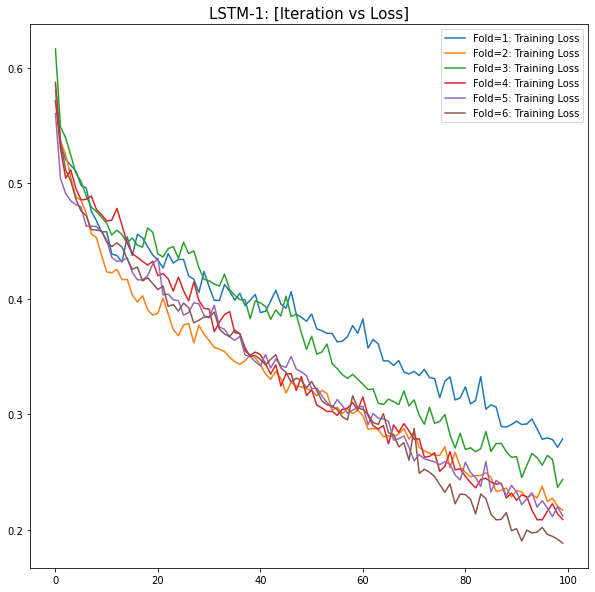

In [9]:
fig = plt.figure(figsize=[10, 10])

plt.plot(hist[0].history['loss'])
plt.plot(hist[1].history['loss'])
plt.plot(hist[2].history['loss'])
plt.plot(hist[3].history['loss'])
plt.plot(hist[4].history['loss'])
plt.plot(hist[5].history['loss'])

plt.title(
    label='LSTM-1: [Iteration vs Loss]',
    fontdict={
        'fontsize': 15,
        'fontweight': 'medium'
    }
)

plt.legend([
    'Fold=1: Training Loss',
    'Fold=2: Training Loss',
    'Fold=3: Training Loss',
    'Fold=4: Training Loss',
    'Fold=5: Training Loss',
    'Fold=6: Training Loss'
])

plt.savefig(
    fname='K-Fold-Train-Loss.png',
    dpi=400
)

plt.show()

### Training Model:

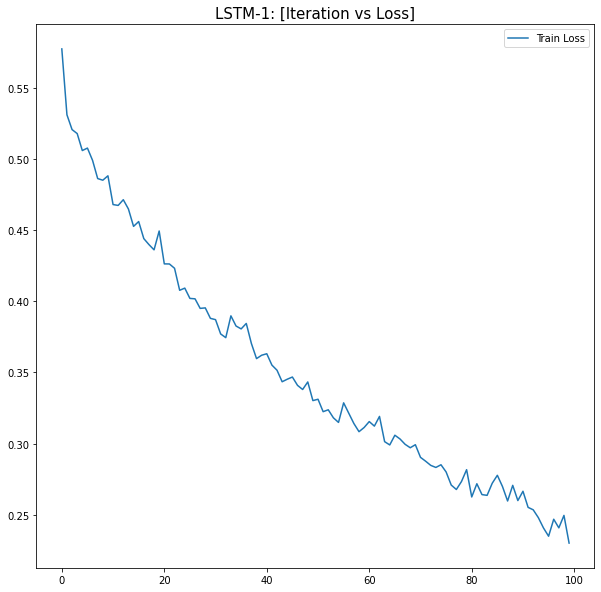

Train Accuracy: 91.35555624961853
Test Accuracy: 85.00000238418579


In [10]:
train_x = []
train_y = []

test_x = []
test_y = []

for entry in processed:

    # Test Set:
    if entry['index'] >= 90 and entry['index'] < 100:
        if entry['ground_truth'] in ['hiphop', 'metal', 'rock', 'pop', 'reggae']:
            test_x += [entry['features']]
            test_y += [tf.keras.utils.to_categorical(0, num_classes=hparams['num_classes'])]
        if entry['ground_truth'] in ['disco', 'country', 'jazz', 'classical', 'blues']:
            test_x += [entry['features']]
            test_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]

    # Train Set:
    else:
        if entry['ground_truth'] in ['hiphop', 'metal', 'rock', 'pop', 'reggae']:
            train_x += [entry['features'].copy()]
            train_y += [tf.keras.utils.to_categorical(0, num_classes=hparams['num_classes'])]
        if entry['ground_truth'] in ['disco', 'country', 'jazz', 'classical', 'blues']:
            train_x += [entry['features'].copy()]
            train_y += [tf.keras.utils.to_categorical(1, num_classes=hparams['num_classes'])]

train_x = np.array(train_x)
train_y = np.array(train_y)

test_x = np.array(test_x)
test_y = np.array(test_y)


# LSTM-1 Model:
model = create_model({
    'L1': 64,
    'L2': 32
})

hist = model.fit(train_x, train_y, epochs=100, verbose=0)

fig = plt.figure(figsize=[10, 10])

plt.plot(hist.history['loss'])

plt.title(
    label='LSTM-1: [Iteration vs Loss]',
    fontdict={
        'fontsize': 15,
        'fontweight': 'medium'
    }
)

plt.legend(['Train Loss'])

plt.savefig(
    fname='LSTM-1-Train-Loss.png',
    dpi=800
)

plt.show()

print('===========================================================')

print('Train Accuracy: {}'.format(100 * model.evaluate(train_x, train_y, verbose=0)[1]))
print('Test Accuracy: {}'.format(100 * model.evaluate(test_x, test_y, verbose=0)[1]))

print('===========================================================')

In [11]:
model.save('./models/model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/model/assets
